# ECE 4200 Font Recognition

## Peihan Gao (NetID: pg477)

### Best Model Overview:

This model was trained in the high-memory (Maximum RAM available: 25.51GB) mode of Colab.

No hardware accelerator (GPU/TPU) was used.

Model: XGBoost

Data Augmentation: rotation, flip, and contrast adjustment

Training Time: 7.4 hours

Training Accuracy: 99.54%

Test Accuracy on the Private Leaderboard: 94.89%

Private Leaderboard Rank: #2

Main Hyperparameters: learning rate = 0.3; max_depth = 9; number of trees = 6; subsample = 0.5; gamma = 0.05

(The corresponding confusion matrix is shown below.)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
font_data = pd.read_csv('/content/drive/MyDrive/ece4200_data/x.csv')

labels = pd.read_csv('/content/drive/MyDrive/ece4200_data/y.csv')
labels = labels.to_numpy()
print(font_data.shape)

(65000, 407)


In [ ]:
import numpy as np
import xgboost as xgb
import time
temp = font_data.to_numpy()

n = temp.shape[0]

temp1 = temp[:,7:]
info = temp[:,0:7]


amp = 1.0
constant = (amp-1.0) * 127.5
temp1 = temp1 * amp - constant
temp1 = np.clip(temp1,0,255)
temp1 = temp1 / 255.0


font_scaled = temp1
info_scaled = (info-info.min(axis=0))/(info.max(axis=0)-info.min(axis=0))

In [ ]:
label_list = ['ARIAL','CALIBRI','CAMBRIA','SERIF','TAHOMA','TIMES']
labelf = labels.flatten()
l = np.unique(labelf)
print(l)
stat = []
for i in l:
     stat.append(np.sum(labelf==i))
print(stat)

label_new = np.zeros(shape=(n),dtype=np.int64)
for i in range(n):
    for j in range(6):
        if labels[i,0] == label_list[j]:
            label_new[i] = j
            break

['ARIAL' 'CALIBRI' 'CAMBRIA' 'SERIF' 'TAHOMA' 'TIMES']
[18115, 13166, 6705, 9159, 9101, 8754]


In [ ]:
import imutils
def data_rot30(x_in, y_train):
    
    y_out = np.concatenate((y_train,y_train,y_train),axis=0)
    
    x_train = x_in[:,7:]
    x2_train = x_in[:,:7]
    
    x2_out = np.concatenate((x2_train,x2_train,x2_train),axis=0)
    
    num_train = x_train.shape[0]
    x = x_train.reshape((num_train,20,20))
    temp = []
    for i in range(num_train):
        rotated = imutils.rotate(x[i], 30)
        temp.append(rotated)

    for i in range(num_train):
        rotated = imutils.rotate(x[i], 60)
        temp.append(rotated)
        
    temp = np.array(temp)
    
    temp = temp.reshape((temp.shape[0],400))
    x_out = np.concatenate((x_train,temp),axis=0)
    x_outc = np.concatenate((x2_out,x_out),axis=1)
    
    return x_outc, y_out

In [ ]:
import imutils

def data_contrast(x_in, y_train):
    
    y_out = np.concatenate((y_train,y_train),axis=0)
    
    x_train = x_in[:,7:]
    x2_train = x_in[:,:7]
    
    x2_out = np.concatenate((x2_train,x2_train),axis=0)
    
    num_train = x_train.shape[0]
    

    amp2 = 1.4
    constant2 = (amp2-1.0) * 0.5
    temp = x_train * amp2 - constant2
    temp = np.clip(temp,0,1)

    
    
    x_out = np.concatenate((x_train,temp),axis=0)
    x_outc = np.concatenate((x2_out,x_out),axis=1)
    
    return x_outc, y_out

In [ ]:
import imutils

def data_contrast2(x_in, y_train):
    
    y_out = np.concatenate((y_train, y_train, y_train),axis=0)
    
    x_train = x_in[:,7:]
    x2_train = x_in[:,:7]
    
    x2_out = np.concatenate((x2_train, x2_train, x2_train),axis=0)
    
    num_train = x_train.shape[0]
    

    amp2 = 1.4
    constant2 = (amp2-1.0) * 0.5
    temp = x_train * amp2 - constant2
    temp = np.clip(temp,0,1)

    amp3 = 1.2
    constant3 = (amp3-1.0) * 0.5
    temp2 = x_train * amp3 - constant3
    temp2 = np.clip(temp2,0,1)
    
    
    x_out = np.concatenate((x_train,temp,temp2),axis=0)
    x_outc = np.concatenate((x2_out,x_out),axis=1)
    
    return x_outc, y_out

In [ ]:
import imutils
import cv2
def data_gaussian(x_in, y_train):
    n_30 = int(0.3 * x_in.shape[0])
    y_out = np.concatenate((y_train,y_train[:n_30]),axis=0)
    
    x_train = x_in[:n_30,7:]
    x2_train = x_in[:,:7]
    
    x2_out = np.concatenate((x2_train,x2_train[:n_30]),axis=0)
    
    num_train = x_train.shape[0]
    x = x_train.reshape((num_train,20,20))
    temp = []
    for i in range(num_train):
        blur = cv2.GaussianBlur(x[i],(5,5),0)
        temp.append(blur)
        
    temp = np.array(temp)
    
    
    temp = temp.reshape((temp.shape[0],400))
    x_out = np.concatenate((x_in[:,7:],temp),axis=0)
    
    x_outc = np.concatenate((x2_out,x_out),axis=1)
    
    return x_outc, y_out

In [ ]:
import copy
def data_augment(x_in, y_train):
    x_train = x_in[:,7:]
    x2_train = x_in[:,:7]
    num_train = x_train.shape[0]
    x = x_train.reshape((num_train,20,20))

    x_f = np.fliplr(x)
    x = np.concatenate((x,x_f),axis=0)
    x2 = np.concatenate((x2_train,x2_train),axis=0)
    y = np.concatenate((y_train,y_train),axis=0)

    x_out = copy.deepcopy(x)
    x2_out = copy.deepcopy(x2)
    y_out = copy.deepcopy(y)


    for i in range(3):
        temp = np.rot90(x,k=i+1,axes=(1,2))
        x_out = np.concatenate((x_out,temp),axis=0)
        x2_out = np.concatenate((x2_out,x2),axis=0)
        y_out = np.concatenate((y_out,y),axis=0)

    new_num = x_out.shape[0]
    x_out = x_out.reshape((new_num,400))
    x_outc = np.concatenate((x2_out,x_out),axis=1)
    return x_outc, y_out

In [ ]:
train_percent = 0.965
train_size = int(train_percent*font_scaled.shape[0])
x_scaled = np.concatenate((info_scaled,font_scaled),axis=1)

x_train, x_test = x_scaled[:train_size], x_scaled[train_size:]
y_train, y_test = label_new[:train_size], label_new[train_size:]

#x_train, y_train = data_gaussian(x_train,y_train)
x_train, y_train = data_augment(x_train,y_train)
x_train, y_train = data_contrast(x_train,y_train)



d_train = xgb.DMatrix(data=x_train, label=y_train)
d_test = xgb.DMatrix(data=x_test,label=y_test)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)



(1003600, 407)
(2275, 407)
(1003600,)
(2275,)


In [ ]:
ep = 400  #epoch


ss = 0.5  #subsample
i = 0.3   #learning rate
j = 9     #max_depth
k = 0.05  #gamma
m = 6     #ntree
n = 1.0   #colsample_bytree


record_raw = "%.2f,%d,%.2f,%d,%.2f,%d,%.2f\n"%(amp,ep,i,j,k,m,n)
print("\nCurrent para: %s"%record_raw)
watchlist=[(d_train,'Train'),(d_test,'Test')]

st = time.time()
clf = xgb.train({'objective': 'multi:softmax', 'eta': i, 'max_depth': j,'gamma':k, 'tree_method': 'hist',
                'num_parallel_tree': m, 'subsample': ss, 'num_class': 6,'colsample_bytree':n},
                                d_train, ep, watchlist)
ed = time.time()

pred = clf.predict(d_test)
y_pred = np.array([round(value) for value in pred])

#score
n_test = x_test.shape[0]
n_correct = np.sum(y_test==y_pred)
acc = n_correct / n_test
time_used = ed - st
print("Test_acc: %.4f"%acc)
print("Time usage: %.4f"%time_used)


best_para = [i,j,k,m,n]
clf.save_model('/content/drive/MyDrive/font_history/best_model_pg477')
              

record = "amp=%.2f, ep=%d, lr=%.2f, max_depth=%d, gamma=%.2f, ntree=%d, subsample=%.2f,colsample_bytree=%.2f: acc=%.4f. \n\n"%(amp,ep,i,j,k,m,ss,n,acc)
with open('/content/drive/MyDrive/font_history/my_models.txt','a') as f:
    f.writelines(record)
            



Current para: 1.00,400,0.30,9,0.05,6,1.00

[0]	Train-merror:0.22165	Test-merror:0.247033
[1]	Train-merror:0.198502	Test-merror:0.224615
[2]	Train-merror:0.185348	Test-merror:0.207912
[3]	Train-merror:0.171311	Test-merror:0.194725
[4]	Train-merror:0.161929	Test-merror:0.185934
[5]	Train-merror:0.153604	Test-merror:0.176264
[6]	Train-merror:0.143615	Test-merror:0.171868
[7]	Train-merror:0.136411	Test-merror:0.168352
[8]	Train-merror:0.130492	Test-merror:0.165714
[9]	Train-merror:0.124446	Test-merror:0.16
[10]	Train-merror:0.118878	Test-merror:0.156044
[11]	Train-merror:0.113627	Test-merror:0.149011
[12]	Train-merror:0.108402	Test-merror:0.146813
[13]	Train-merror:0.103464	Test-merror:0.144615
[14]	Train-merror:0.099316	Test-merror:0.140659
[15]	Train-merror:0.09529	Test-merror:0.136703
[16]	Train-merror:0.091511	Test-merror:0.134505
[17]	Train-merror:0.087137	Test-merror:0.130549
[18]	Train-merror:0.083258	Test-merror:0.129231
[19]	Train-merror:0.080155	Test-merror:0.124835
[20]	Train-m

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
font_data = pd.read_csv('/content/drive/MyDrive/ece4200_data/x.csv')

labels = pd.read_csv('/content/drive/MyDrive/ece4200_data/y.csv')
labels = labels.to_numpy()

In [ ]:
import numpy as np
import xgboost as xgb
import time
temp = font_data.to_numpy()

n = temp.shape[0]

temp1 = temp[:,7:]
info = temp[:,0:7]


amp = 1.0
constant = (amp-1.0) * 127.5
temp1 = temp1 * amp - constant
temp1 = np.clip(temp1,0,255)
temp1 = temp1 / 255.0

min_train = info.min(axis=0)
max_train = info.max(axis=0)

font_scaled = temp1
info_scaled = (info-min_train)/(max_train-min_train)


In [ ]:
label_list = ['ARIAL','CALIBRI','CAMBRIA','SERIF','TAHOMA','TIMES']
labelf = labels.flatten()
l = np.unique(labelf)
print(l)
stat = []
for i in l:
     stat.append(np.sum(labelf==i))
print(stat)

label_new = np.zeros(shape=(n),dtype=np.int64)
for i in range(n):
    for j in range(6):
        if labels[i,0] == label_list[j]:
            label_new[i] = j
            break

['ARIAL' 'CALIBRI' 'CAMBRIA' 'SERIF' 'TAHOMA' 'TIMES']
[18115, 13166, 6705, 9159, 9101, 8754]


In [ ]:
train_percent = 0.965
train_size = int(train_percent*font_scaled.shape[0])
x_scaled = np.concatenate((info_scaled,font_scaled),axis=1)

x_train, x_test = x_scaled[:train_size], x_scaled[train_size:]
y_train, y_test = label_new[:train_size], label_new[train_size:]

d_train = xgb.DMatrix(data=x_train, label=y_train)
d_test = xgb.DMatrix(data=x_test,label=y_test)

In [ ]:
clf = xgb.Booster()
clf.load_model('/content/drive/MyDrive/font_history/best_model_pg477')
pred_train = clf.predict(d_train)
pred = clf.predict(d_test)

y_pred = np.array([round(value) for value in pred])
y_pred_train = np.array([round(value) for value in pred_train])

#score
n_test = x_test.shape[0]
n_correct = np.sum(y_test==y_pred)
n_correct_train = np.sum(y_train==y_pred_train)
acc = n_correct / n_test
acc_t = n_correct_train / (65000 - n_test)
print("Train_acc: %.4f"%acc_t)
print("Test_acc: %.4f"%acc)

Train_acc: 0.9954
Test_acc: 0.9543


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

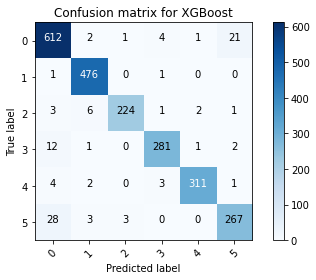

In [ ]:
cfm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cfm, classes=range(6), 
                      title='Confusion matrix for XGBoost')

In [ ]:
font_task = pd.read_csv('/content/drive/MyDrive/ece4200_data/unlabeled.csv')

temp2 = font_task.to_numpy()

temp3 = temp2[:,7:]
info2 = temp2[:,0:7]


temp3 = temp3 * amp - constant
temp3 = np.clip(temp3,0,255)
temp3 = temp3 / 255.0


font_scaled2 = temp3
info_scaled2 = (info2-min_train)/(max_train-min_train)

x_task = np.concatenate((info_scaled2,font_scaled2),axis=1)
d_task = xgb.DMatrix(data=x_task)

pred_task = clf.predict(d_task)
y_task = pred_task.astype(dtype=np.int64)

In [ ]:
n_task = y_task.shape[0]

label_task = []
for i in y_task:
    label_task.append(label_list[i])
label_task = np.array(label_task)
idx_task = np.arange(1,n_task+1)

print(label_task.shape)

my_predict = pd.DataFrame({'ID':idx_task,
                          'Font':label_task
                          })

my_predict.to_csv('/content/drive/MyDrive/ece4200_data/predict_pg477.csv',index=False)

(29221,)
